<a href="https://colab.research.google.com/github/KeerthiVasudevan/diffusion-saliency/blob/main/Diffsusion_saliency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from google.colab import files
import kagglehub
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt




In [ ]:
!pip install kaggle


In [ ]:
files.upload()

NameError: name 'files' is not defined

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
path = kagglehub.dataset_download("balraj98/duts-saliency-detection-dataset")
print("Path to dataset files:", path)



100%|██████████| 392M/392M [00:03<00:00, 104MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/duts-saliency-detection-dataset/versions/1


In [4]:
train_path = os.path.join(path, "DUTS-TR")
test_path = os.path.join(path, "DUTS-TE")
train_images_path = os.path.join(train_path, "DUTS-TR-Image")
train_saliency_path = os.path.join(train_path, "DUTS-TR-Mask")
test_images_path = os.path.join(test_path, "DUTS-TE-Image")
test_saliency_path = os.path.join(test_path, "DUTS-TE-Mask")

In [5]:
# Image Transform (for RGB images)
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to 128x128
    transforms.ToTensor(),           # Convert to tensor (shape: [3, 128, 128])
])

# Saliency Transform (convert to 3 channels)
saliency_transform = transforms.Compose([
    transforms.Resize((128, 128)),                   # Resize saliency maps to 128x128
    transforms.Grayscale(num_output_channels=3),     # Convert to 3 channels
    transforms.ToTensor(),                           # Convert to tensor (shape: [3, 128, 128])
])


class SaliencyDataset(Dataset):
  def __init__(self, image_dir, saliency_dir, image_transform, saliency_transform):
    self.image_dir = image_dir
    self.saliency_dir = saliency_dir
    self.image_transform = image_transform
    self.saliency_transform = saliency_transform
    self.image_files = sorted(os.listdir(image_dir))
    self.saliency_files = sorted(os.listdir(saliency_dir))
    assert len(self.image_files) == len(self.saliency_files)

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    image_name = self.image_files[idx]
    name_without_extension = os.path.splitext(image_name)[0]
    saliency_name = name_without_extension + ".png"
    image_path = os.path.join(self.image_dir, self.image_files[idx])
    # saliency_path = os.path.join(self.saliency_dir, self.saliency_files[idx])
    saliency_path = os.path.join(self.saliency_dir, saliency_name)
    # print("Index: ", idx)
    try:
      image = Image.open(image_path)
      saliency = Image.open(saliency_path)
    except FileNotFoundError:
      print(f"Image file not found: {image_path}")
      print(f"Saliency file not found: {saliency_path}")
      return None
    # image = Image.open(image_path)
    # saliency = Image.open(saliency_path)
    # if self.transform:
    #   image = self.transform(image)
    #   saliency = self.transform(saliency)

    # Apply respective transforms
    if self.image_transform:
        image = self.image_transform(image)
    if self.saliency_transform:
        saliency = self.saliency_transform(saliency)

    return image, saliency

# Dataset and DataLoader
dataset = SaliencyDataset(image_dir=train_images_path, saliency_dir=train_saliency_path, image_transform=image_transform, saliency_transform=saliency_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [6]:
# UNET

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -torch.log(torch.tensor(10000.0)) / (half_dim - 1))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return self.mlp(emb)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

# Encoder Block: ConvBlock + MaxPooling
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        features = self.conv_block(x)  # Extracted features
        pooled = self.pool(features)   # Downsampled features
        return features, pooled


# Decoder Block: Upsampling + Skip Connection + ConvBlock
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(out_channels * 2, out_channels)  # *2 for concatenation with skip features
        self.time_mlp = nn.Linear(time_dim, out_channels)

    def forward(self, x, skip_features, t_embed):
        x = self.upsample(x)                           # Upsample
        x = torch.cat([x, skip_features], dim=1)       # Concatenate skip features
        # t_embed = self.time_mlp(t_embed).unsqueeze(-1).unsqueeze(-1)
        # x = x + t_embed                                # Add timestep embedding

        # Project time embedding to match x's channels
        t_embed = self.time_mlp(t_embed)  # Shape: (batch_size, channels)
        t_embed = t_embed.view(t_embed.shape[0], -1, 1, 1)  # Add spatial dimensions

        # Dynamically match channels using a 1x1 Conv layer if needed
        if t_embed.shape[1] != x.shape[1]:
            t_embed = nn.Conv2d(t_embed.shape[1], x.shape[1], kernel_size=1).to(x.device)(t_embed)

        # Add time embedding to x
        x = x + t_embed
        x = self.conv_block(x)                         # Apply convolutional block
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim=256):
        super(UNet, self).__init__()

        self.time_embedding = TimeEmbedding(time_dim)
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)
        self.bottleneck_time_embedding = nn.Linear(time_dim, 1024) # Timestep conditioning

        # self.dec4 = DecoderBlock(1024, 512)
        # self.dec3 = DecoderBlock(512, 256)
        # self.dec2 = DecoderBlock(256, 128)
        # self.dec1 = DecoderBlock(128, 64)

        self.dec4 = DecoderBlock(1024, 512, time_dim)
        self.dec3 = DecoderBlock(512, 256, time_dim)
        self.dec2 = DecoderBlock(256, 128, time_dim)
        self.dec1 = DecoderBlock(128, 64, time_dim)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)


    # def forward(self, x):
    #     enc1_features, enc1_pooled = self.enc1(x)
    #     enc2_features, enc2_pooled = self.enc2(enc1_pooled)
    #     enc3_features, enc3_pooled = self.enc3(enc2_pooled)
    #     enc4_features, enc4_pooled = self.enc4(enc3_pooled)

    #     bottleneck = self.bottleneck(enc4_pooled)

    #     dec4 = self.dec4(bottleneck, enc4_features)
    #     dec3 = self.dec3(dec4, enc3_features)
    #     dec2 = self.dec2(dec3, enc2_features)
    #     dec1 = self.dec1(dec2, enc1_features)
    #     output = self.final_conv(dec1)

    #     return output

    def forward(self, x, t, image_features):
        # Time embedding
        t_embed = self.time_embedding(t)

        # Encoder path
        enc1_features, enc1_pooled = self.enc1(x + image_features)
        enc2_features, enc2_pooled = self.enc2(enc1_pooled)
        enc3_features, enc3_pooled = self.enc3(enc2_pooled)
        enc4_features, enc4_pooled = self.enc4(enc3_pooled)

        # Bottleneck with timestep conditioning
        bottleneck = self.bottleneck(enc4_pooled) + self.bottleneck_time_embedding(t_embed).unsqueeze(-1).unsqueeze(-1)

        # Decoder path with timestep
        dec4 = self.dec4(bottleneck, enc4_features, t_embed)
        dec3 = self.dec3(dec4, enc3_features, t_embed)
        dec2 = self.dec2(dec3, enc2_features, t_embed)
        dec1 = self.dec1(dec2, enc1_features, t_embed)
        output = self.final_conv(dec1)

        return output






# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()

#     def encoder_block(self, in_channels, out_channels):
#       x = self.conv_block(in_channels, out_channels)
#       p = nn.MaxPool2d(kernel_size=2, stride=2)(x)
#       return x, p



#     def decoder_block(self, in_channels, out_channels, skip_features):
#       x = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)(x)
#       x = torch.cat([skip_features, x], dim=1)
#       x = self.conv_block(out_channels * 2, out_channels)
#       return x

#     def forward(self, x):
#       x1, p1 = self.encoder_block(x, 64)
#       x2, p2 = self.encoder_block(p1, 128)
#       x3, p3 = self.encoder_block(p2, 256)
#       x4, p4 = self.encoder_block(p3, 512)
#       x5 = self.conv_block(p4, 1024)
#       d4 = self.decoder_block(x5, 512, x4)
#       d3 = self.decoder_block(d5, 256, x3)
#       d2 = self.decoder_block(d4, 128, x2)
#       d1 = self.decoder_block(d3, 64, x1)
#       output = nn.Conv2d(64, out_channels, kernel_size=1)(d1)
#       return output



In [ ]:
# # Diffusion model

# class DiffusionSaliencyModel(nn.Module):
#     def __init__(self, unet, timesteps=1000, beta_start=0.0001, beta_end=0.02, device = "cpu"):
#         super(DiffusionSaliencyModel, self).__init__()
#         self.unet = unet
#         self.timesteps = timesteps

#         self.device = device
#         # Noise schedule
#         self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
#         self.alpha = 1 - self.beta
#         self.alpha_bar = torch.cumprod(self.alpha, dim=0)

#     def add_noise(self, saliency_map, t):
#         """
#         Add noise to the saliency map.
#         """
#         t = t.to(torch.long).to(self.alpha_bar.device)
#         noise = torch.randn_like(saliency_map)
#         alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
#         # print(f"t shape: {t.shape}")

#         # print(f"alpha_bar_t shape: {alpha_bar_t.shape}")
#         # print(f"saliency_map shape: {saliency_map.shape}")
#         # print(f"noise shape: {noise.shape}")

#         noisy_map = torch.sqrt(alpha_bar_t) * saliency_map + torch.sqrt(1 - alpha_bar_t) * noise
#         return noisy_map, noise

#     def forward(self, saliency_map, image_features, t):
#       """
#       Forward pass through the diffusion model.
#       Predict noise in the noisy saliency map.
#       """
#       noisy_map, noise = self.add_noise(saliency_map, t)
#       predicted_noise = self.unet(noisy_map, t, image_features)
#       return F.mse_loss(predicted_noise, noise)



In [7]:
# Add noise
def get_noise_schedule(timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cpu"):
    beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta, alpha, alpha_bar


def add_noise(saliency_map, alpha_bar, t):
    """
    Add noise to the saliency map.
    """
    t = t.to(torch.long).to(alpha_bar.device)
    noise = torch.randn_like(saliency_map)
    alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
    noisy_map = torch.sqrt(alpha_bar_t) * saliency_map + torch.sqrt(1 - alpha_bar_t) * noise
    return noisy_map, noise

In [22]:
# Training

unet = UNet(in_channels=3, out_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beta_start = 1e-6  # Very small initial noise
beta_end = 1e-3    # Gradually increase to a small value

# diffusion_model = DiffusionSaliencyModel(unet, device=device)
# diffusion_model = DiffusionSaliencyModel(unet, beta_start=beta_start, beta_end=beta_end, device=device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-5)
unet.to(device)
timesteps = 1000
beta, alpha, alpha_bar = get_noise_schedule(timesteps=timesteps, beta_start=beta_start, beta_end=beta_end, device=device)
criterion = nn.MSELoss();
unet.train()

for epoch in range(10):  # Number of epochs
    for image, saliency_map in tqdm(dataloader):
        if saliency_map is None:
            continue
        image, saliency_map = image.to(device), saliency_map.to(device)

        t = torch.randint(0, timesteps, (saliency_map.shape[0],), dtype=torch.long).to(device)

        # loss = diffusion_model(saliency_map, image, t)

        noise = torch.randn_like(saliency_map)
        alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)  # Extract alpha_bar for each timestep
        noisy_map = torch.sqrt(alpha_bar_t) * saliency_map + torch.sqrt(1 - alpha_bar_t) * noise

        predicted_saliency_map = unet(noisy_map, t, image)

        loss = criterion(predicted_saliency_map, saliency_map)


        # noisy_map, noise = add_noise(saliency_map, alpha_bar, t)
        # predicted_noise = unet(noisy_map, t, image)
        # loss = criterion(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


  0%|          | 0/1320 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 3, 128, 128])) that is different to the input size (torch.Size([8, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 1318/1320 [01:20<00:00, 16.15it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 3, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1320/1320 [01:21<00:00, 16.29it/s]


Epoch 1, Loss: 0.007343277335166931


100%|██████████| 1320/1320 [01:21<00:00, 16.17it/s]


Epoch 2, Loss: 0.006677336059510708


100%|██████████| 1320/1320 [01:22<00:00, 16.03it/s]


Epoch 3, Loss: 0.013272449374198914


100%|██████████| 1320/1320 [01:22<00:00, 16.04it/s]


Epoch 4, Loss: 0.08162301033735275


100%|██████████| 1320/1320 [01:22<00:00, 16.04it/s]


Epoch 5, Loss: 0.002170371590182185


100%|██████████| 1320/1320 [01:22<00:00, 16.03it/s]


Epoch 6, Loss: 0.0012840552954003215


100%|██████████| 1320/1320 [01:22<00:00, 16.04it/s]


Epoch 7, Loss: 0.019874893128871918


100%|██████████| 1320/1320 [01:22<00:00, 16.02it/s]


Epoch 8, Loss: 0.07562527805566788


100%|██████████| 1320/1320 [01:22<00:00, 16.02it/s]


Epoch 9, Loss: 0.03794291988015175


100%|██████████| 1320/1320 [01:22<00:00, 16.02it/s]

Epoch 10, Loss: 0.0022062656935304403


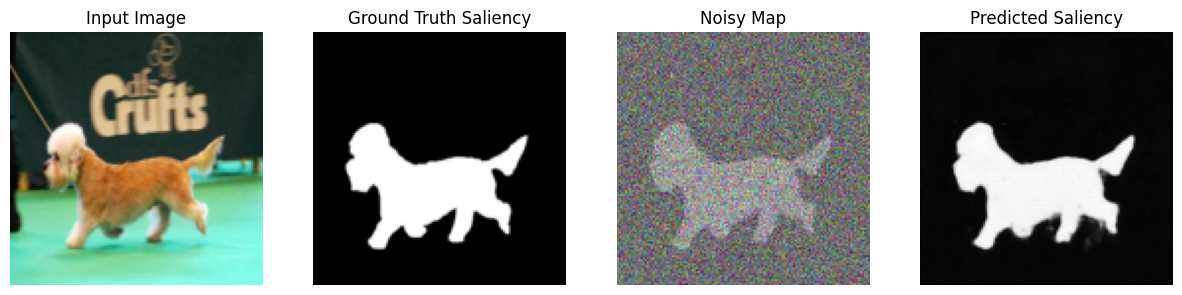

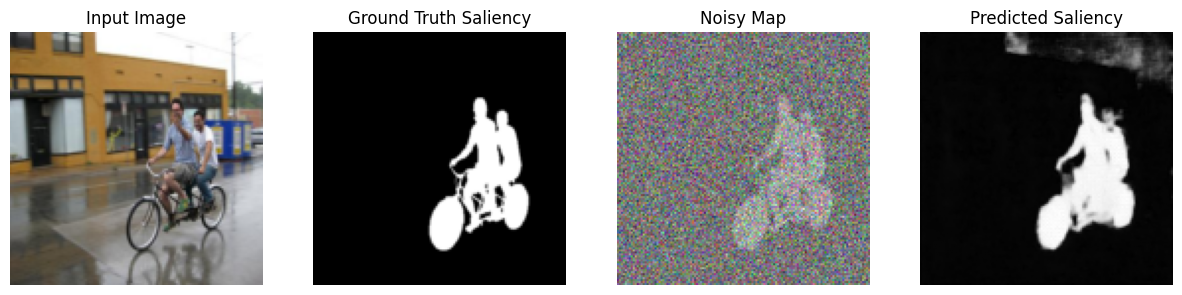

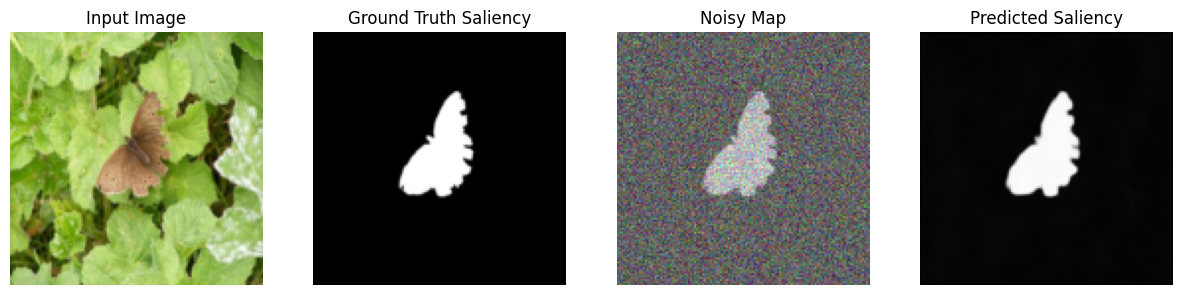

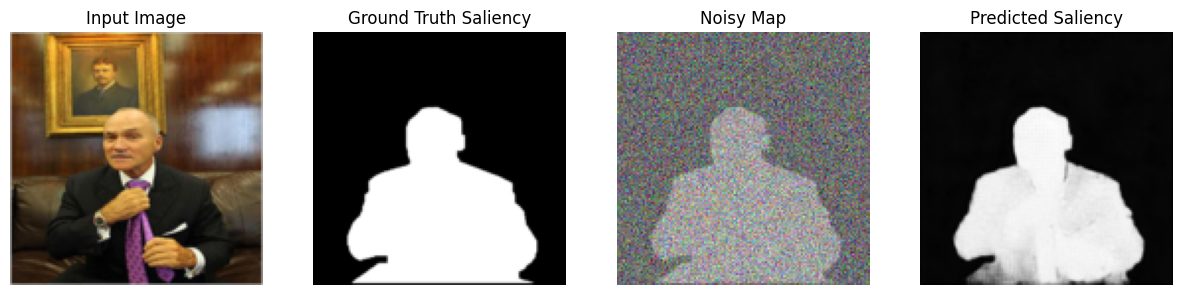

Average Test Loss: 0.1546


In [23]:
# Test

test_dataset = SaliencyDataset(image_dir=test_images_path, saliency_dir=test_saliency_path, image_transform=image_transform, saliency_transform=saliency_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for i, (images, saliency_maps) in enumerate(dataloader):
            images = images.to(device)
            saliency_maps = saliency_maps.to(device)

            # Random timestep for testing
            t = torch.randint(0, timesteps, (saliency_maps.shape[0],), dtype=torch.long).to(device)

            # Get loss and predictions

            noise = torch.randn_like(saliency_maps)
            alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
            noisy_map = torch.sqrt(alpha_bar_t) * saliency_maps + torch.sqrt(1 - alpha_bar_t) * noise

            predicted_saliency_map = unet(noisy_map, t, images)

            # noisy_map, noise = add_noise(saliency_maps, alpha_bar, t)
            # predicted_noise = model(noisy_map, t, images)
            loss = criterion(predicted_saliency_map, saliency_map)
            total_loss += loss.item()
            # Visualize a few examples
            if i < 4:  # Display first 4 examples
                # Normalize and process images for visualization
                img = images[0].permute(1, 2, 0).cpu()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

                saliency = saliency_maps[0].permute(1, 2, 0).squeeze().cpu()
                saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

                noisy = noisy_map[0].permute(1, 2, 0).squeeze().cpu()
                noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())

                predicted = predicted_saliency_map[0].permute(1, 2, 0).squeeze().cpu()
                predicted = (predicted - predicted.min()) / (predicted.max() - predicted.min())

                # Plot
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 4, 1)
                plt.imshow(img)
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 4, 2)
                plt.imshow(saliency, cmap="gray")
                plt.title("Ground Truth Saliency")
                plt.axis("off")

                plt.subplot(1, 4, 3)
                plt.imshow(noisy, cmap="gray")
                plt.title("Noisy Map")
                plt.axis("off")

                plt.subplot(1, 4, 4)
                plt.imshow(predicted, cmap="gray")
                plt.title("Predicted Saliency")
                plt.axis("off")

                plt.show()



    avg_loss = total_loss / len(dataloader)
    print(f"Average Test Loss: {avg_loss:.4f}")

evaluate_model(unet, test_dataloader, device)


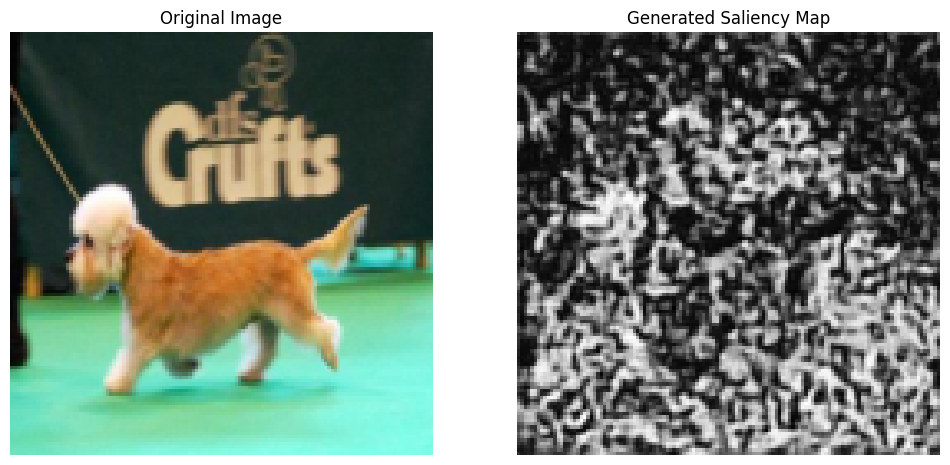

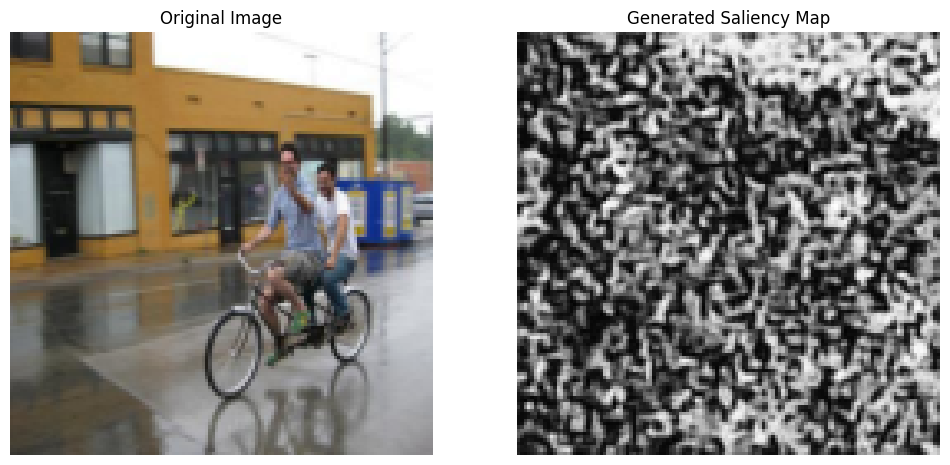

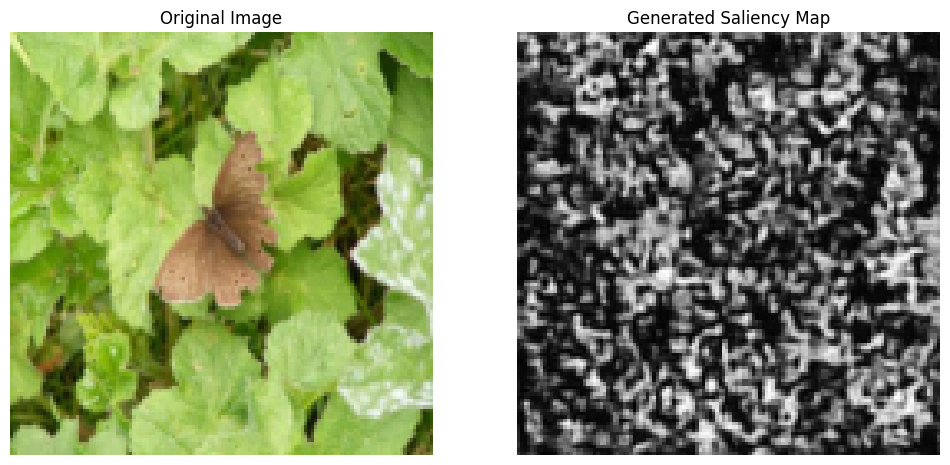

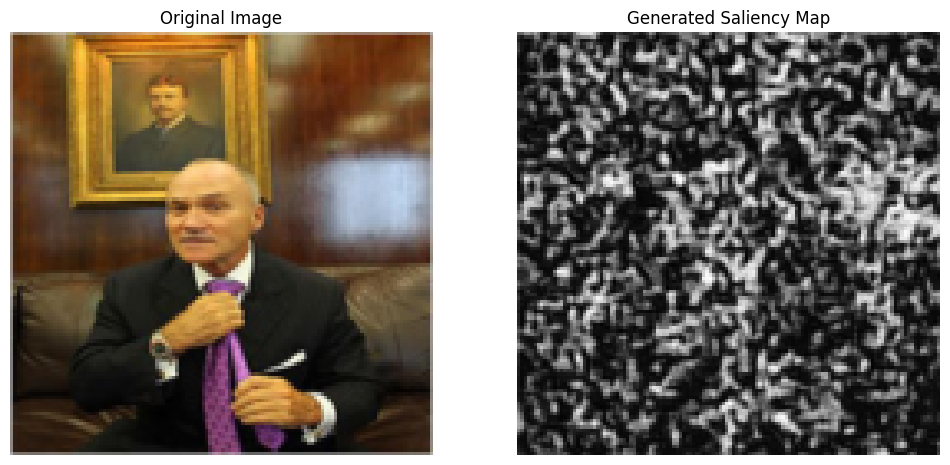

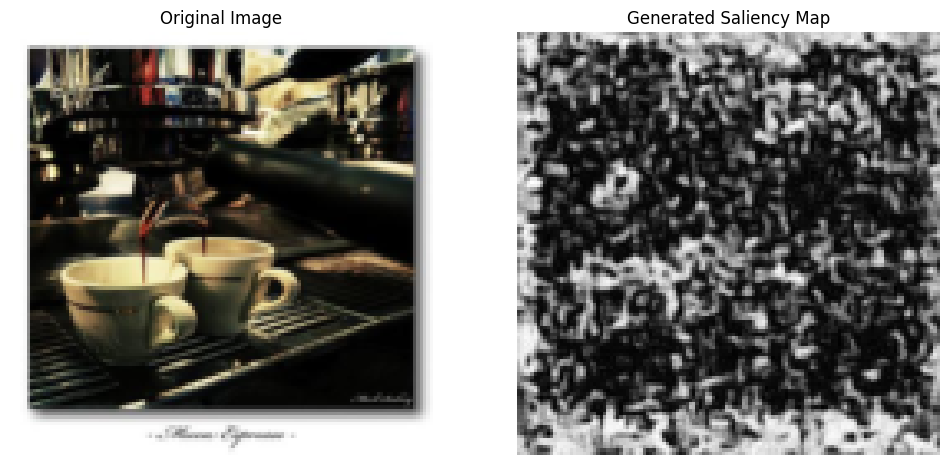

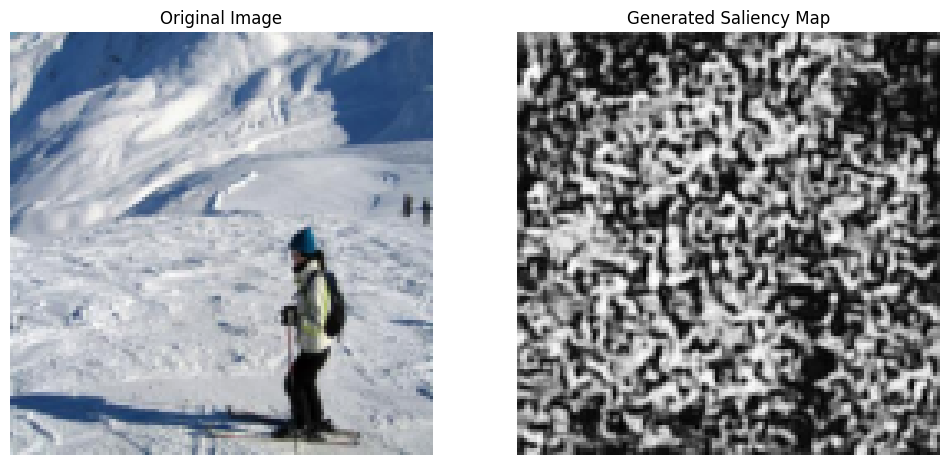

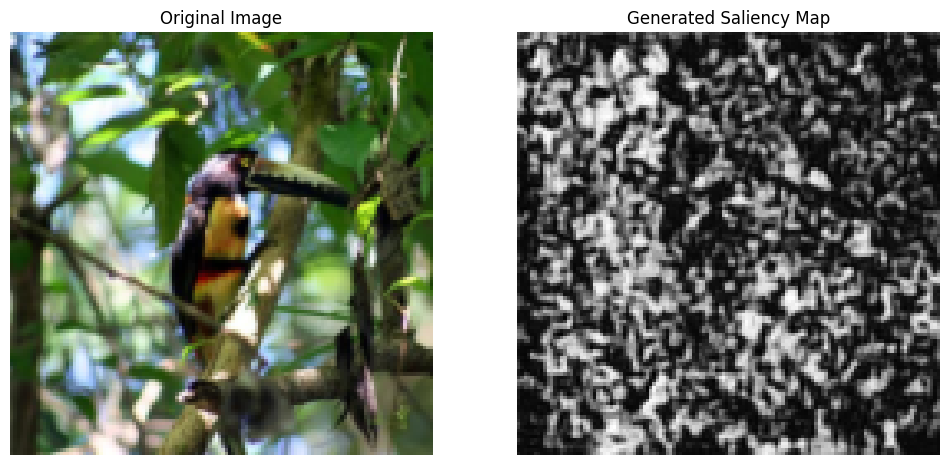

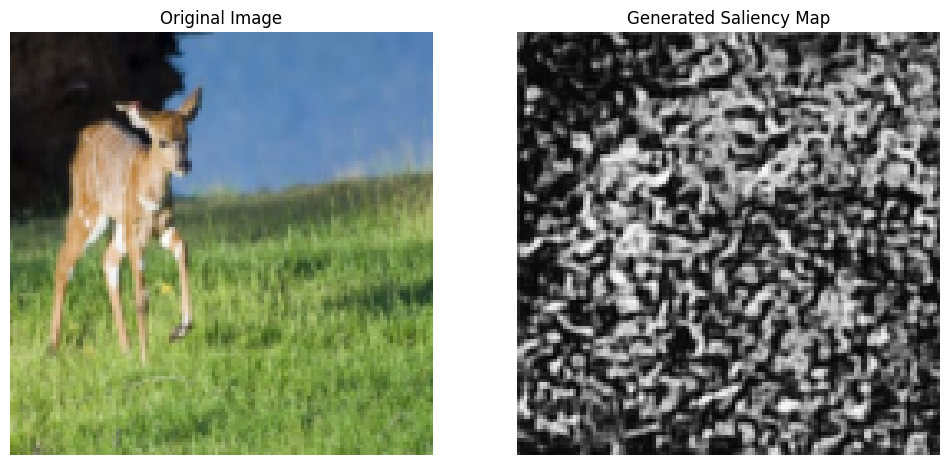

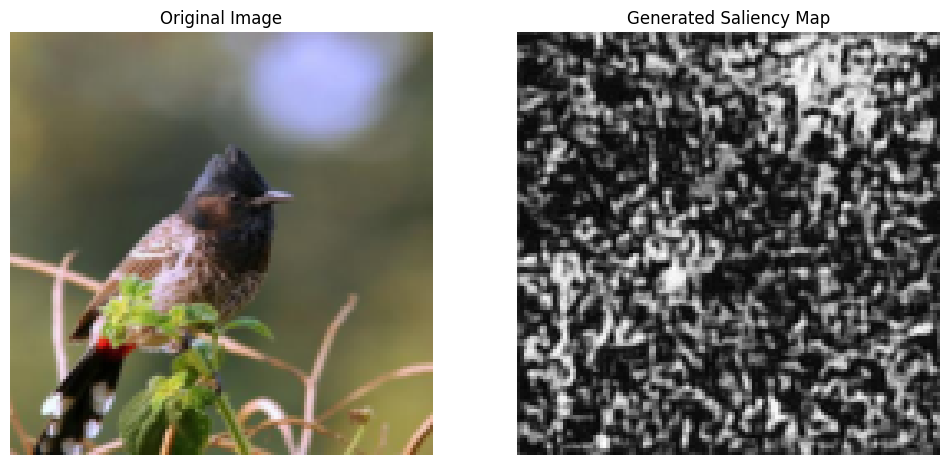

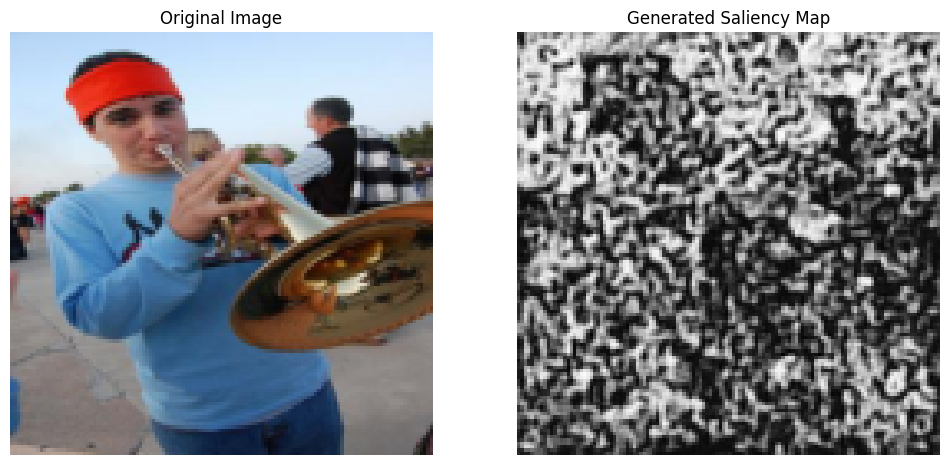

In [29]:
# Generate saliency maps
def generate_saliency_maps(model, dataloader, device):
    model.eval()
    index = 0
    with torch.no_grad():
        for i, (image, saliency_map) in enumerate(dataloader):
            index = index + 1
            if index > 10:
                break
            image = image.to(device)

            # Generate saliency map
            noisy_map = torch.randn_like(image[:, 0:1, :, :])  # Start with a blank map
            for t in reversed(range(timesteps)):  # Iteratively denoise
               t_tensor = torch.full((image.size(0),), t, dtype=torch.long).to(device)  # Batch of t values
               predicted_saliency = model(noisy_map, t_tensor, image)

               noisy_map = predicted_saliency

            # Visualize the result
            saliency_map = noisy_map.squeeze().cpu().numpy()  # Remove batch and channel dims
            original_image = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

            # Normalize image for display
            original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(original_image)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(saliency_map, cmap="gray")
            plt.title("Generated Saliency Map")
            plt.axis("off")

            plt.show()




            # # Visualize the result
            # saliency_map = noisy_map.squeeze().cpu().numpy()
            # original_image = image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

            # # Normalize image for display if needed
            # original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

            # plt.figure(figsize=(12, 6))
            # plt.subplot(1, 2, 1)
            # plt.imshow(original_image)
            # plt.title("Original Image")
            # plt.axis("off")



            # plt.subplot(1, 2, 2)
            # plt.imshow(saliency_map, cmap="gray")
            # plt.title("Generated Saliency Map")
            # plt.axis("off")

            # plt.show()


# Run the generation
generate_saliency_maps(unet, test_dataloader, device)

In [ ]:
print("First 10 image and saliency maps")
image_files = sorted(os.listdir(test_images_path))
saliency_map_files = sorted(os.listdir(test_saliency_path))
for i in range(len(image_files)):
  image_path = os.path.join(test_images_path, image_files[i])
  saliency_map_path = os.path.join(test_saliency_path, saliency_map_files[i])
  # check for jpg images
  if image_path.endswith("03127747_6750.jpg"):
    print("image: ", image_path)
    print("saliency map: ", saliency_map_path)
  if saliency_map_path.endswith("03127747_6750.jpg"):
    print("image: ", image_path)
    print("saliency map: ", saliency_map_path)



First 10 image and saliency maps


SyntaxError: invalid syntax (<ipython-input-22-1d3ed27388f2>, line 1)